We begin by reading in the data:

In [19]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/Projects-in-ML-and-AI/HW2/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


This data is a list of mushrooms and their features. 'class' is the classification target: a 'p' indicates the mushroom is poisonous, while an 'e' indicates edible. The models in this notebook will aim to predict the edibility of a mushroom from its other features.

---

Let's check to see if any data cleaning is necessary. We'll do this by first looking to see which values are present in each column.

In [20]:
df.value_counts(normalize=True)*100

class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  gill-spacing  gill-size  gill-color  stalk-shape  stalk-root  stalk-surface-above-ring  stalk-surface-below-ring  stalk-color-above-ring  stalk-color-below-ring  veil-type  veil-color  ring-number  ring-type  spore-print-color  population  habitat
p      x          y            y          f        n     f                c             n          w           e            ?           k                         y                         w                       y                       p          w           o            e          w                  v           d          0.012309
e      x          f            n          f        n     f                w             b          n           t            e           s                         f                         w                       w                       p          w           o            e          k                  a           g          0.012309
          

Column 'stalk-root' has '?' values, while the rest only have alphabet characters. Let's see how many '?' values are present in 'stalk-root':

In [21]:
df[df['stalk-root'] == '?']

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
3984,e,x,y,b,t,n,f,c,b,e,e,?,s,s,e,w,p,w,t,e,w,c,w
4023,p,x,y,e,f,y,f,c,n,b,t,?,k,s,w,w,p,w,o,e,w,v,p
4076,e,f,y,u,f,n,f,c,n,h,e,?,s,f,w,w,p,w,o,f,h,y,d
4100,p,x,y,e,f,y,f,c,n,b,t,?,k,s,p,p,p,w,o,e,w,v,d
4104,p,x,y,n,f,f,f,c,n,b,t,?,s,s,p,p,p,w,o,e,w,v,l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l


2480 rows have a '?' value in 'stalk-root' out of a total of 8124, roughly a third of the rows. These values are worthless, and would throw off the results of the data. Testing models with and without the column didn't show a significant difference in accuracy, while dropping a third of the dataset by removing each row with a '?' is too great of a loss of data. 

We'll drop 'stalk-root':

In [22]:
df = df.drop('stalk-root', 1)
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,s,s,w,w,p,w,o,e,n,a,g


Every remaining value is an alphabetical character. Let's convert each entry in the dataset into numerical values to allow for training:

In [23]:
df = df.apply(lambda r : r.apply(lambda v : ord(v) - 96)) #a -> 1, b -> 2, ..., z -> 26

Next we split the dataset into arrays of data and labels, then those into training sets and testing sets. We'll allocate 20% of data for testing, 80% for training.

In [24]:
from sklearn.model_selection import train_test_split  

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

Now we build the model, a DecisionTreeClassifier from scikit-learn.

This problem is well suited for a decision tree model. Attributes in this dataset have easily separable categories, each of which have different correlations with edibility. A decision tree aims to find the attribute value thresholds that best divide the dataset into edible or poisonous mushrooms.

We'll begin with default parameters.

In [25]:
from sklearn import metrics
from sklearn import tree
import time

defaultModel = tree.DecisionTreeClassifier()
timeStart = time.time()
defaultModel.fit(X_train,y_train)
timeEnd = time.time()

prediction = defaultModel.predict(X_test)
accuracy = metrics.accuracy_score(prediction,y_test) #mean accuracy on the predictions of X_test with respect to y_test
precision = metrics.precision_score(prediction,y_test, average='micro') #mean precision on the predictions of X_test with respect to y_test
#while this is a binary classification (a mushroom is either 'e' or 'p'), sklearn would not allow a 'binary' average when scoring precision


print('The accuracy of the tree is %0.2f%%, with a precision of %0.2f%%, taking %0.4f seconds to train.' % (accuracy*100, precision*100, timeEnd-timeStart))

The accuracy of the tree is 100.00%, with a precision of 100.00%, taking 0.0116 seconds to train.


This tree fits the data perfectly. That indicates that the model found patterns of attributes that exactly correlate with edibility for every mushroom in the dataset. If any future mushrooms don't follow this pattern, they'd be misclassified by the model. It's possible that every mushroom follows those patterns, in which case the model is a perfect general fit, but it's more likely that the model fit itself to patterns and biases just present in this dataset. That would be an overfit. Perfect accuracies tend to indicate overfitting.

Let's visualize the tree to observe what it's doing:

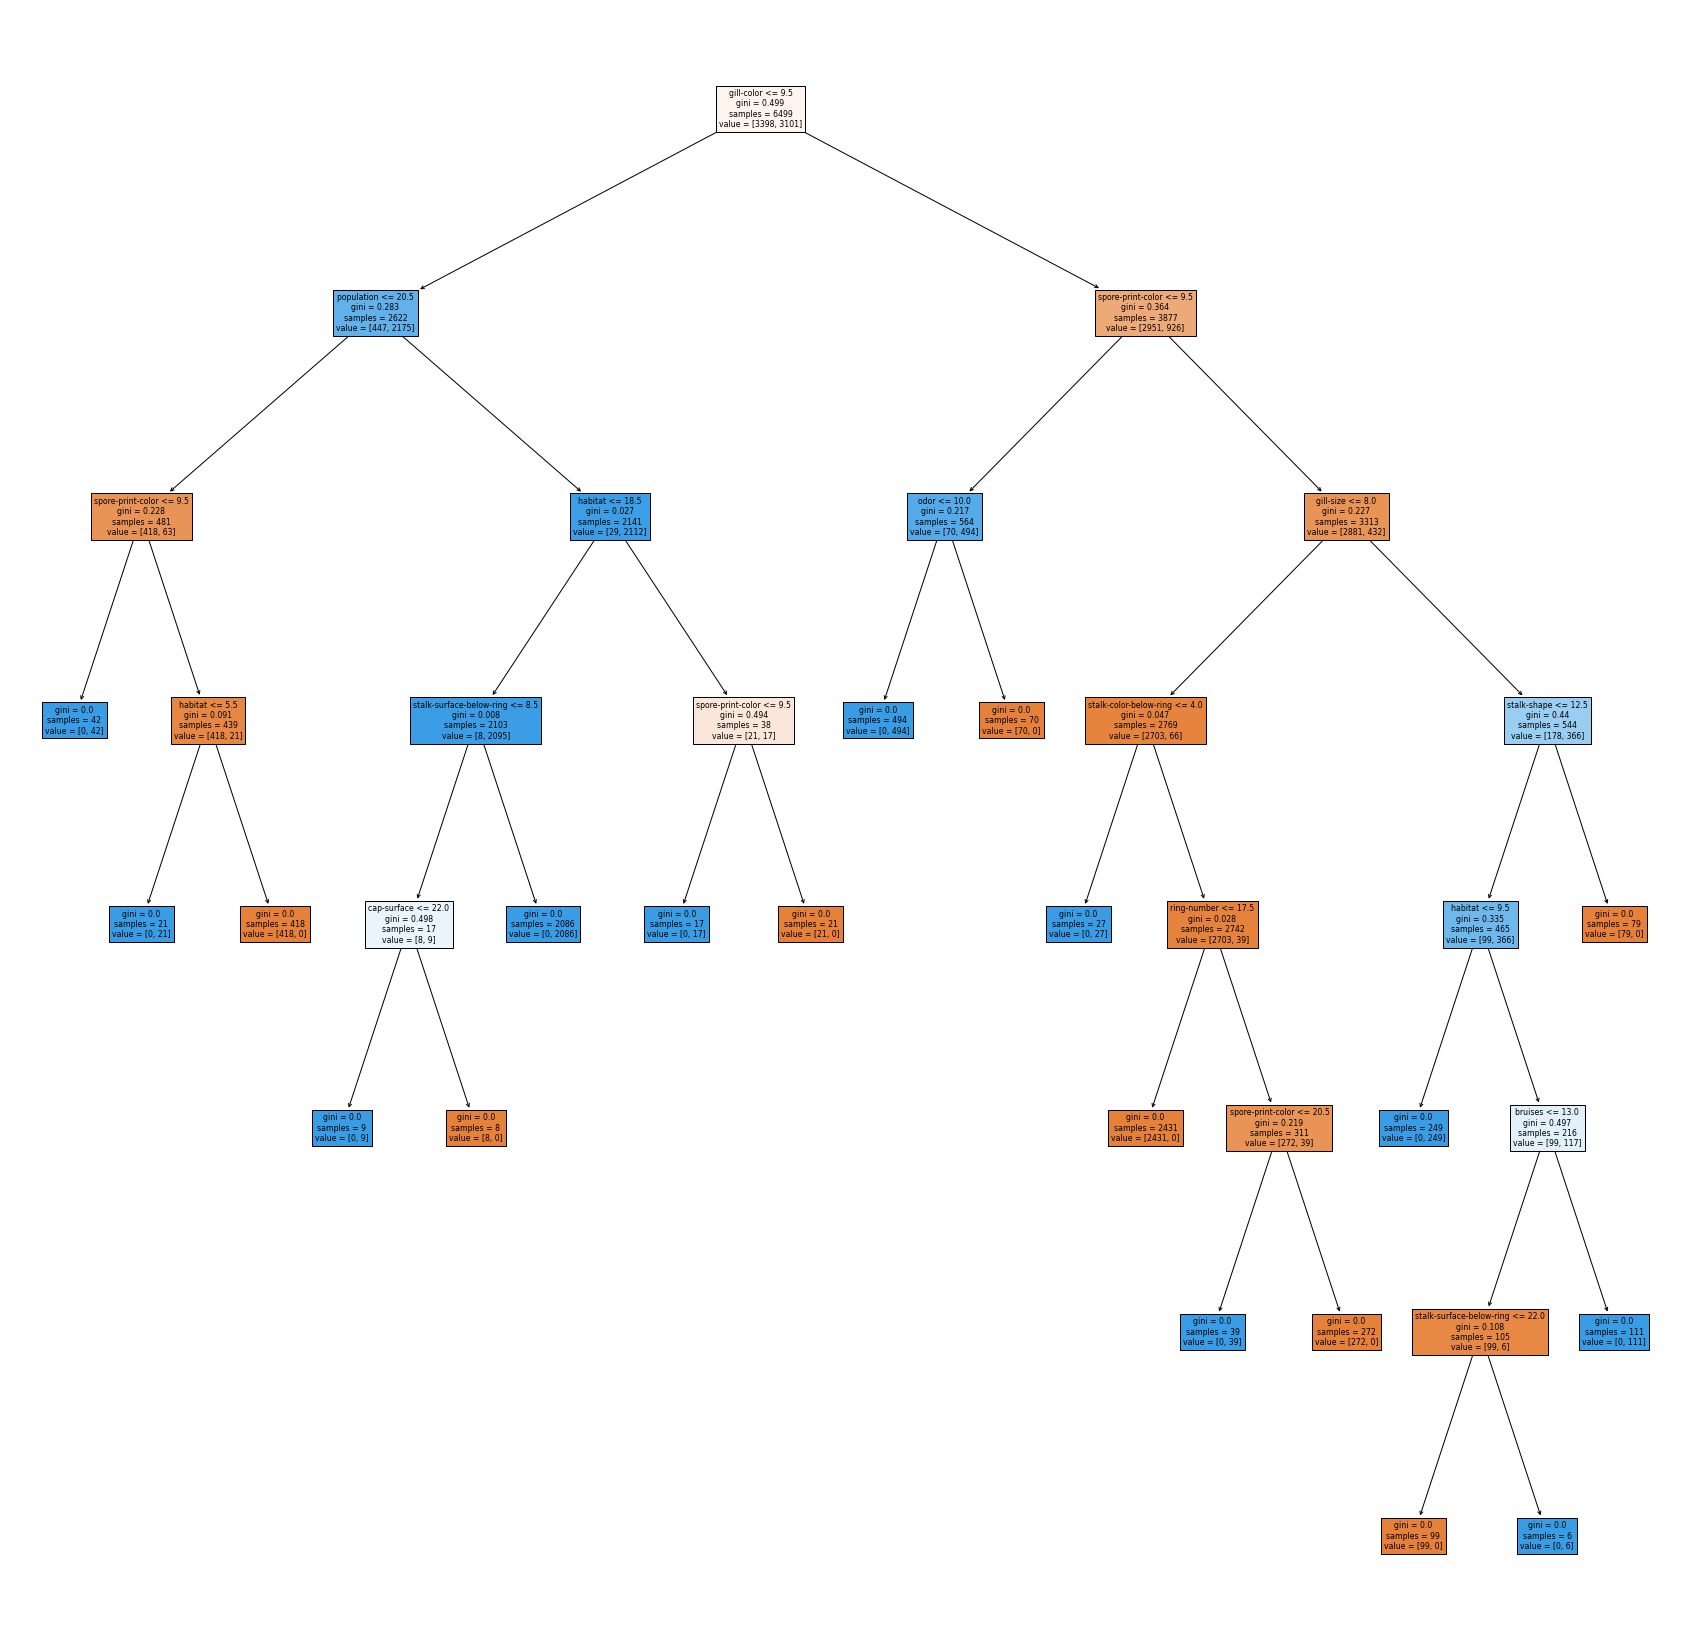

In [26]:
from matplotlib import pyplot as plt

colNames = list(df)

fig = plt.figure(figsize=(30,30))
tree.plot_tree(defaultModel, filled=True, feature_names=colNames[1:])
fig.savefig("default_tree.png")

This is a deep tree, at seven levels. Impurity decreases rapidly down the tree, with most level three nodes having a small gini. That indicates that the dataspace is easily separable, validating a decision tree as an appropriate model for this classification problem. 

However, the model is overfitting, with an accuracy of 100%. This could hurt the generalizability of the model towards mushrooms unseen to the model, by recognizing biases present specifically in this dataset as patterns present across all mushrooms.

---

To help combat overfitting, we can introduce a value into min_impurity_decrease. 

According to scikit's website, ["A node will be split if this split induces a decrease of the impurity greater than or equal to \[the value of min_impurity_decrease]"](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). So if the sample at a node is at the defined threshold of impurity, it'll split. This will allow for less specific leaf nodes, which would have an impurity of roughly min_impurity_decrease or less. While these less specific samplesets will be less accurate with regard to the dataset, they're less likely to be fitting to biases present within it.

Let's implement a new model with this change:


In [27]:
modifiedModel = tree.DecisionTreeClassifier(min_impurity_decrease=0.01)
timeStart = time.time()
modifiedModel.fit(X_train,y_train)
timeEnd = time.time()

prediction = modifiedModel.predict(X_test)
accuracy = metrics.accuracy_score(prediction,y_test) #mean accuracy on the predictions of X_test with respect to y_test
precision = metrics.precision_score(prediction,y_test, average='micro') #mean precision on the predictions of X_test with respect to y_test
#while this is a binary classification (a mushroom is either 'e' or 'p'), sklearn would not allow a 'binary' average when scoring precision


print('The accuracy of the modified tree is %0.2f%%, with a precision of %0.2f%%, taking %0.4f seconds to train.' % (accuracy*100, precision*100, timeEnd-timeStart))

The accuracy of the modified tree is 96.98%, with a precision of 96.98%, taking 0.0183 seconds to train.


This accuracy score, ~97%, indicates that the model is more likely to be generalizable past this dataset into future examples than the default model. This took roughly the same time to train.

Let's visualize the tree:

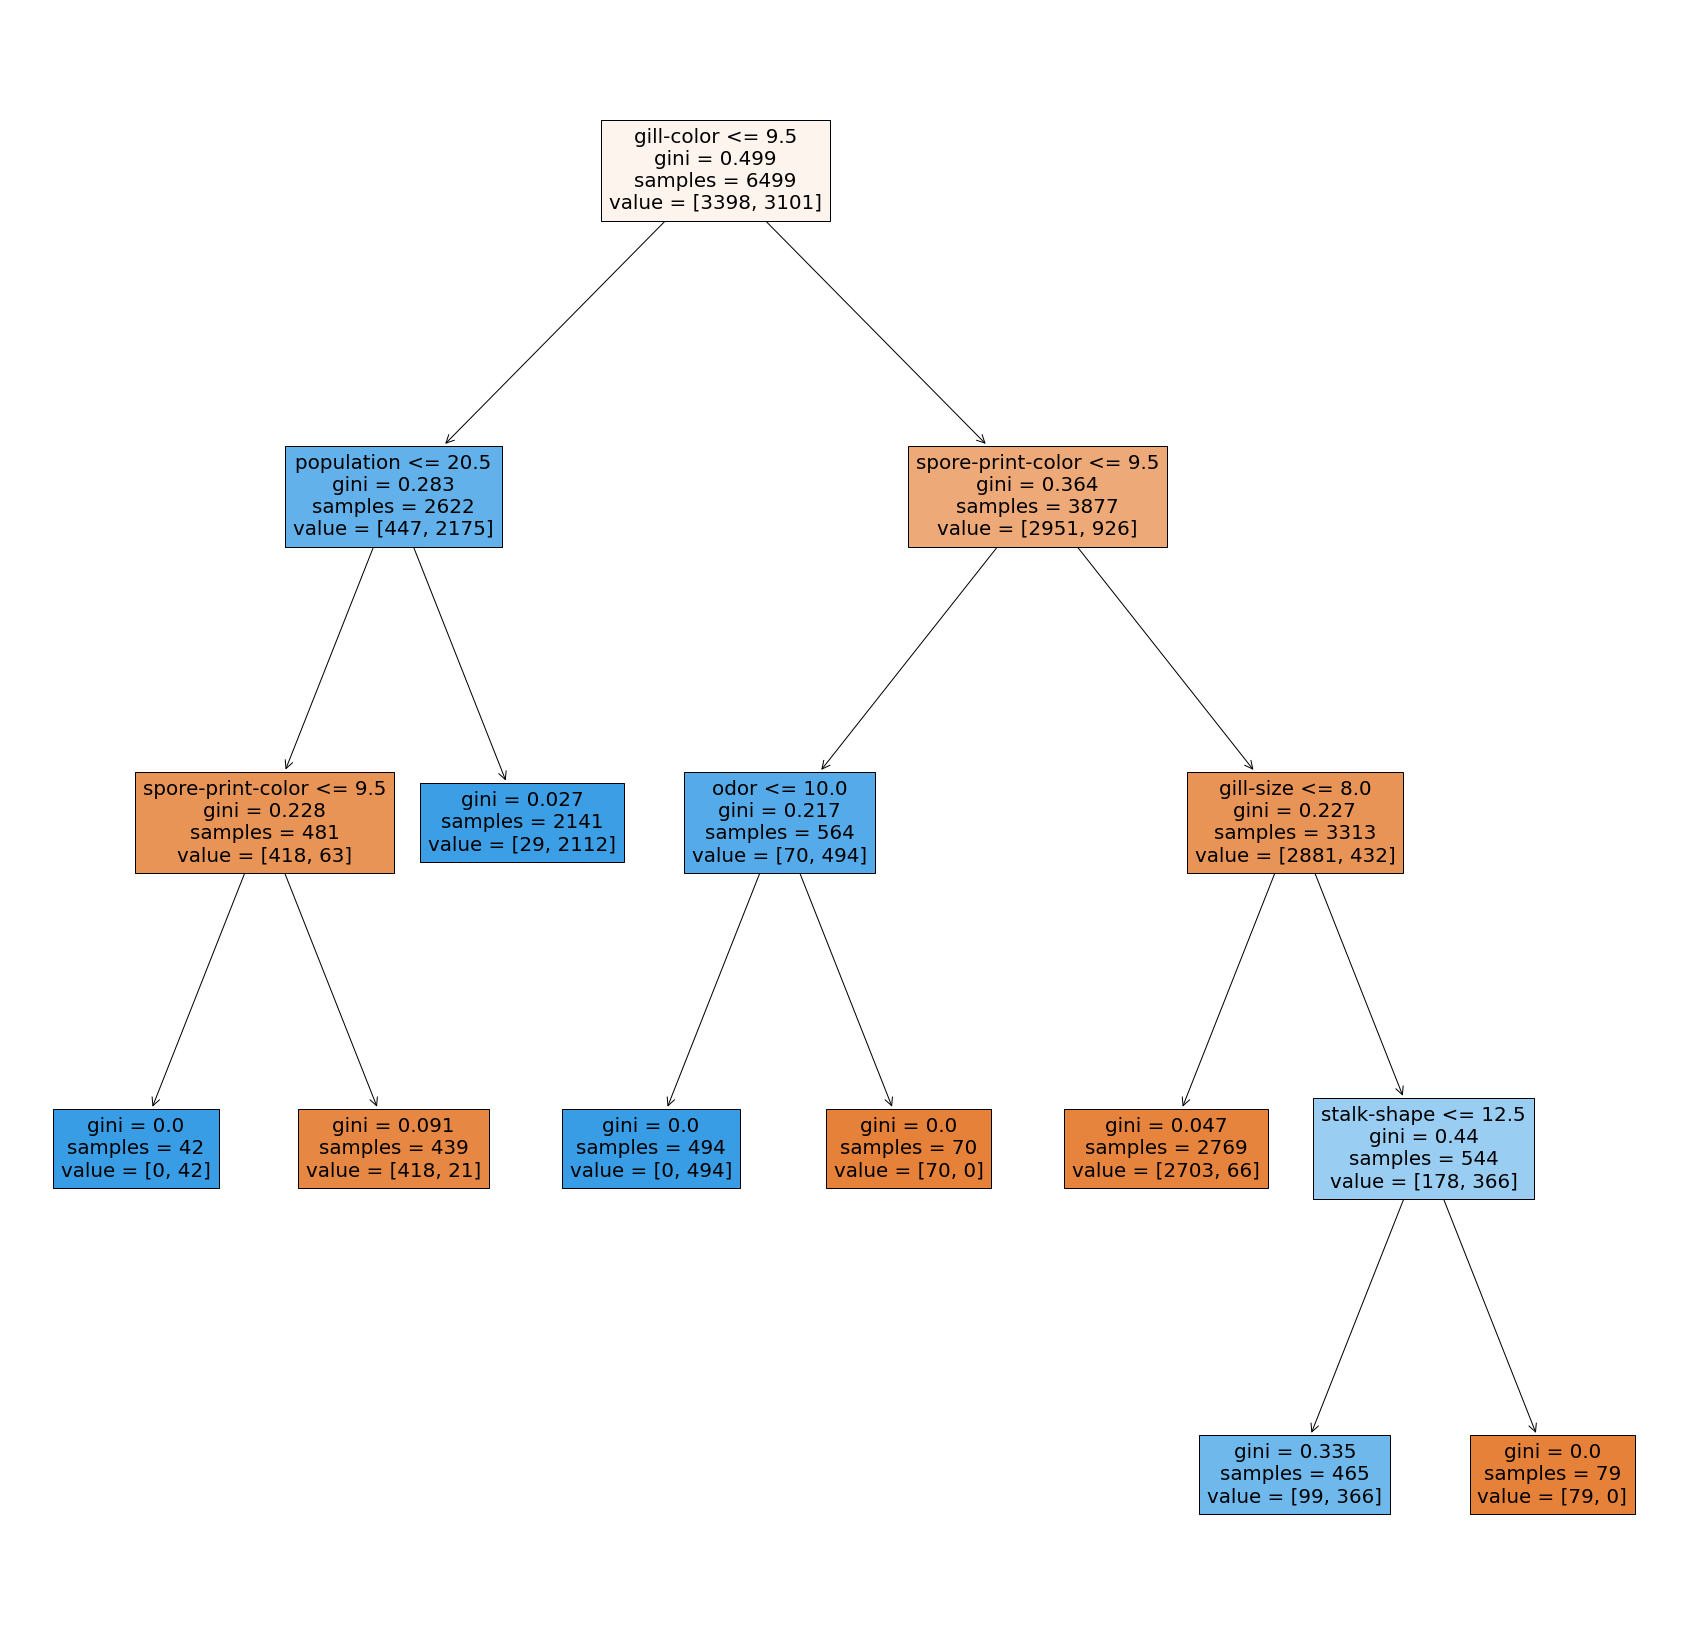

In [28]:
fig = plt.figure(figsize=(30,30))
tree.plot_tree(modifiedModel, filled=True, feature_names=colNames[1:])
fig.savefig("impurity_decrease_tree.png")

The leaves on this tree have larger sample sizes, and there are less nodes total. This contributes to the lower accuracy, but indicates that the model is more likely to be generalizable. 


---


Another parameter to help combat an overfit is to choose a lower max depth of the tree. This is especially applicable here since the impurity of nodes in each level decreased rapidly in the default model. 

It was observed that by level three of the default tree, the impurity values of most nodes was already low. Let's implement a decision tree classifier with a max depth of three:

In [29]:
modifiedModel = tree.DecisionTreeClassifier(max_depth=3)
timeStart = time.time()
modifiedModel.fit(X_train,y_train)
timeEnd = time.time()

prediction = modifiedModel.predict(X_test)
accuracy = metrics.accuracy_score(prediction,y_test) #mean accuracy on the predictions of X_test with respect to y_test
precision = metrics.precision_score(prediction,y_test, average='micro') #mean precision on the predictions of X_test with respect to y_test
#while this is a binary classification (a mushroom is either 'e' or 'p'), sklearn would not allow a 'binary' average when scoring precision


print('The accuracy of the 3-depth tree is %0.2f%%, with a precision of %0.2f%%, taking %0.4f seconds to train.' % (accuracy*100, precision*100, timeEnd-timeStart))

The accuracy of the 3-depth tree is 95.69%, with a precision of 95.69%, taking 0.0098 seconds to train.


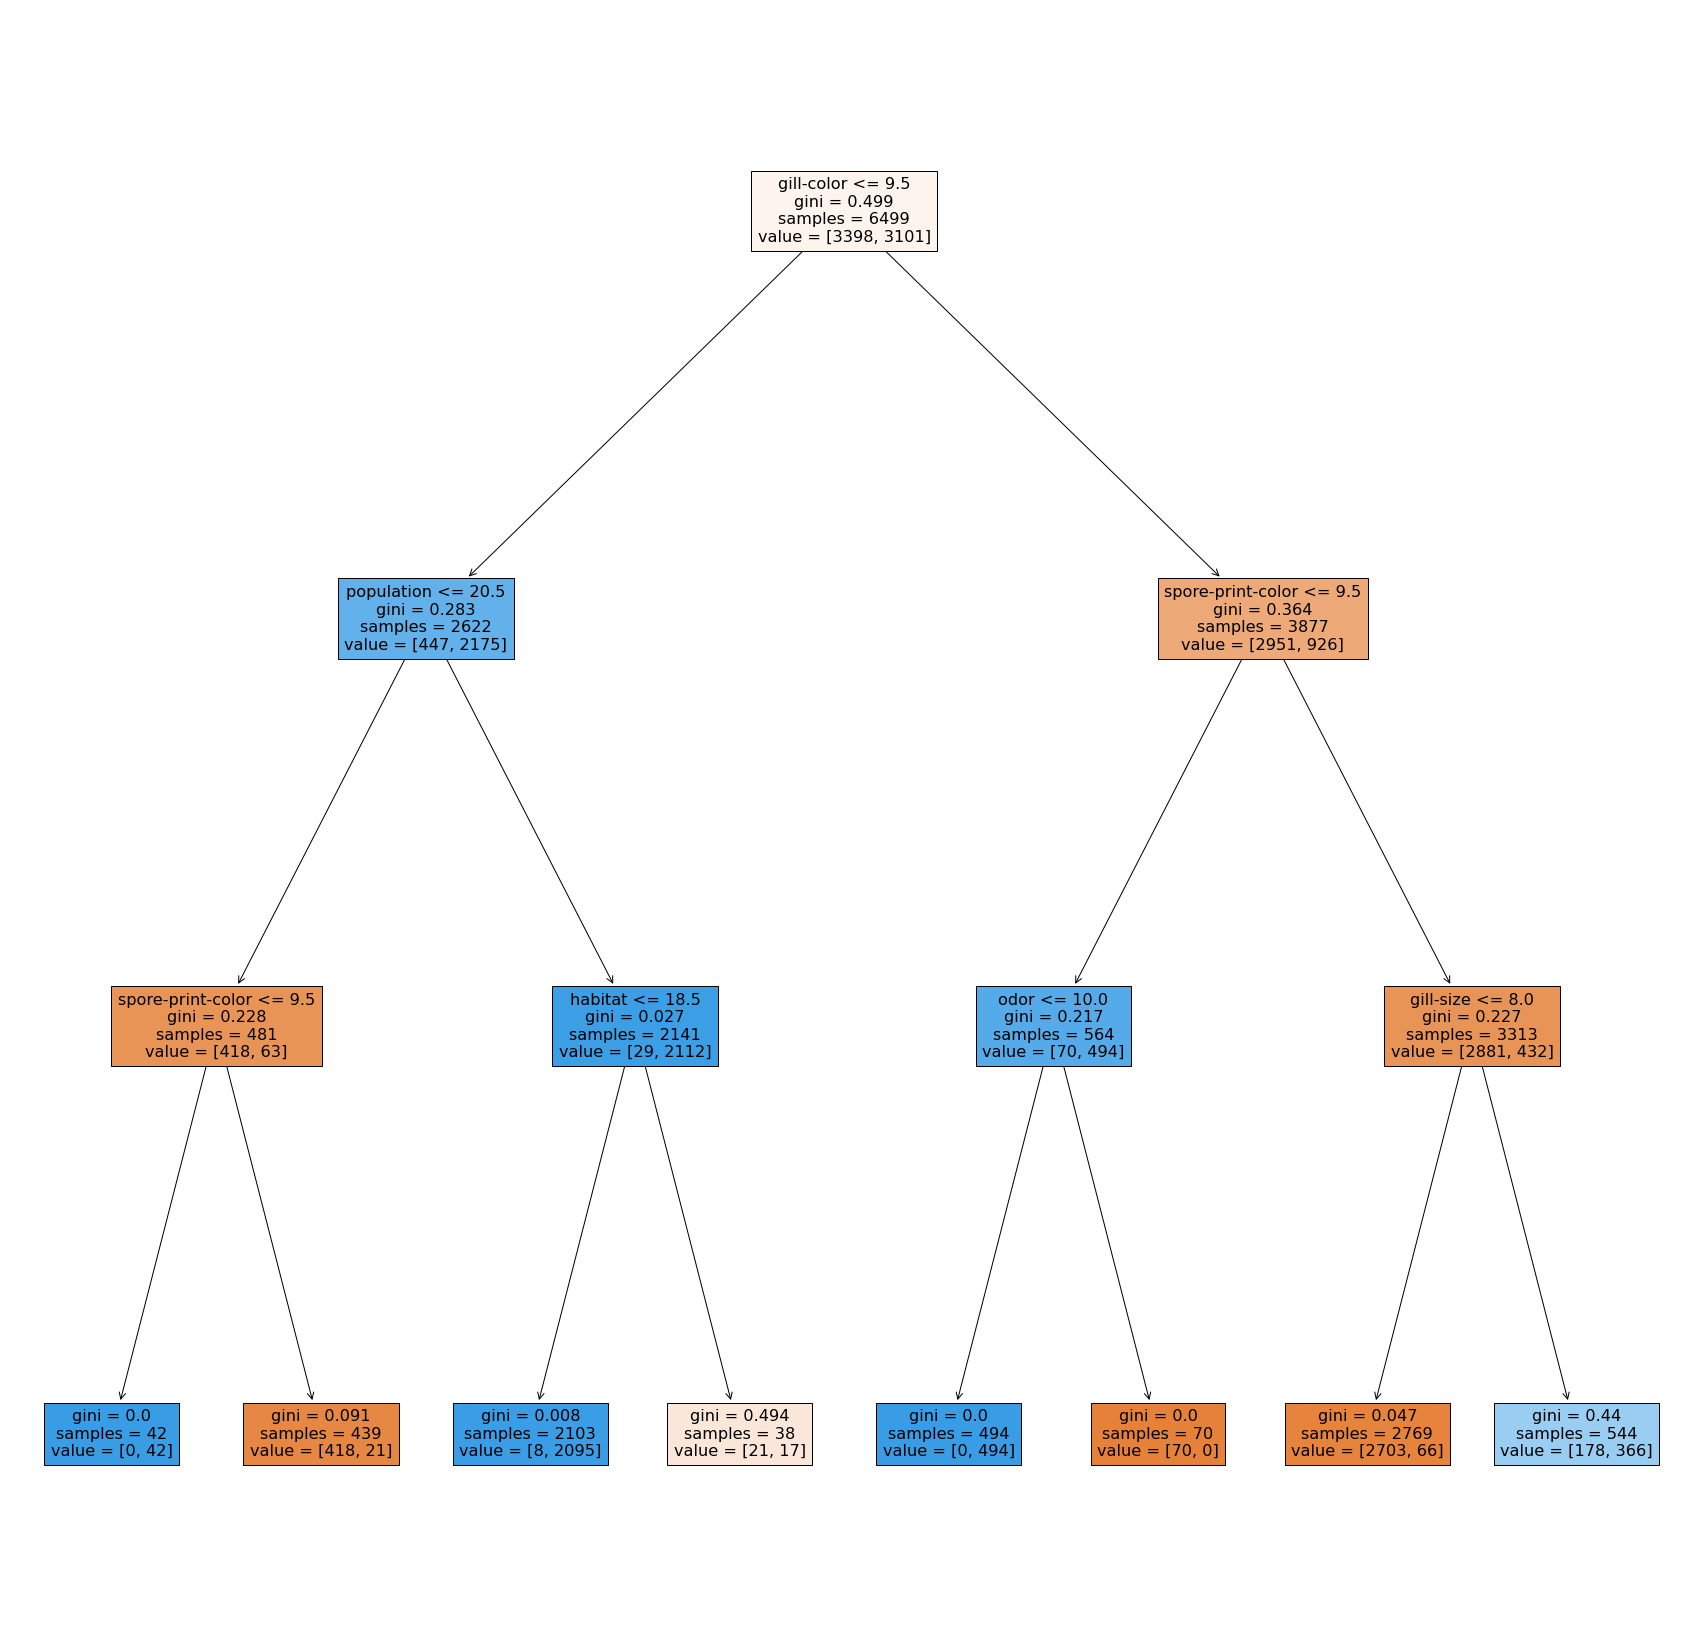

In [30]:
fig = plt.figure(figsize=(30,30))
tree.plot_tree(modifiedModel, filled=True, feature_names=colNames[1:])
fig.savefig("shallow_depth_tree.png")

A lower depth will tend to make a faster, but less accurate model, while higher depths do the opposite but have a higher risk of an overfit. That's exactly what we see here. Even with a depth of just 3, this data seems to be easily separable, with the model retaining ~96% accuracy. The attributes on the first and second levels appear to split the data very well on their own, with successive levels refining the purity of each sample set. Let's examine a tree with a depth of 2:

The accuracy of the 2-depth tree is 92.00%, with a precision of 92.00%, taking 0.0071 seconds to train.


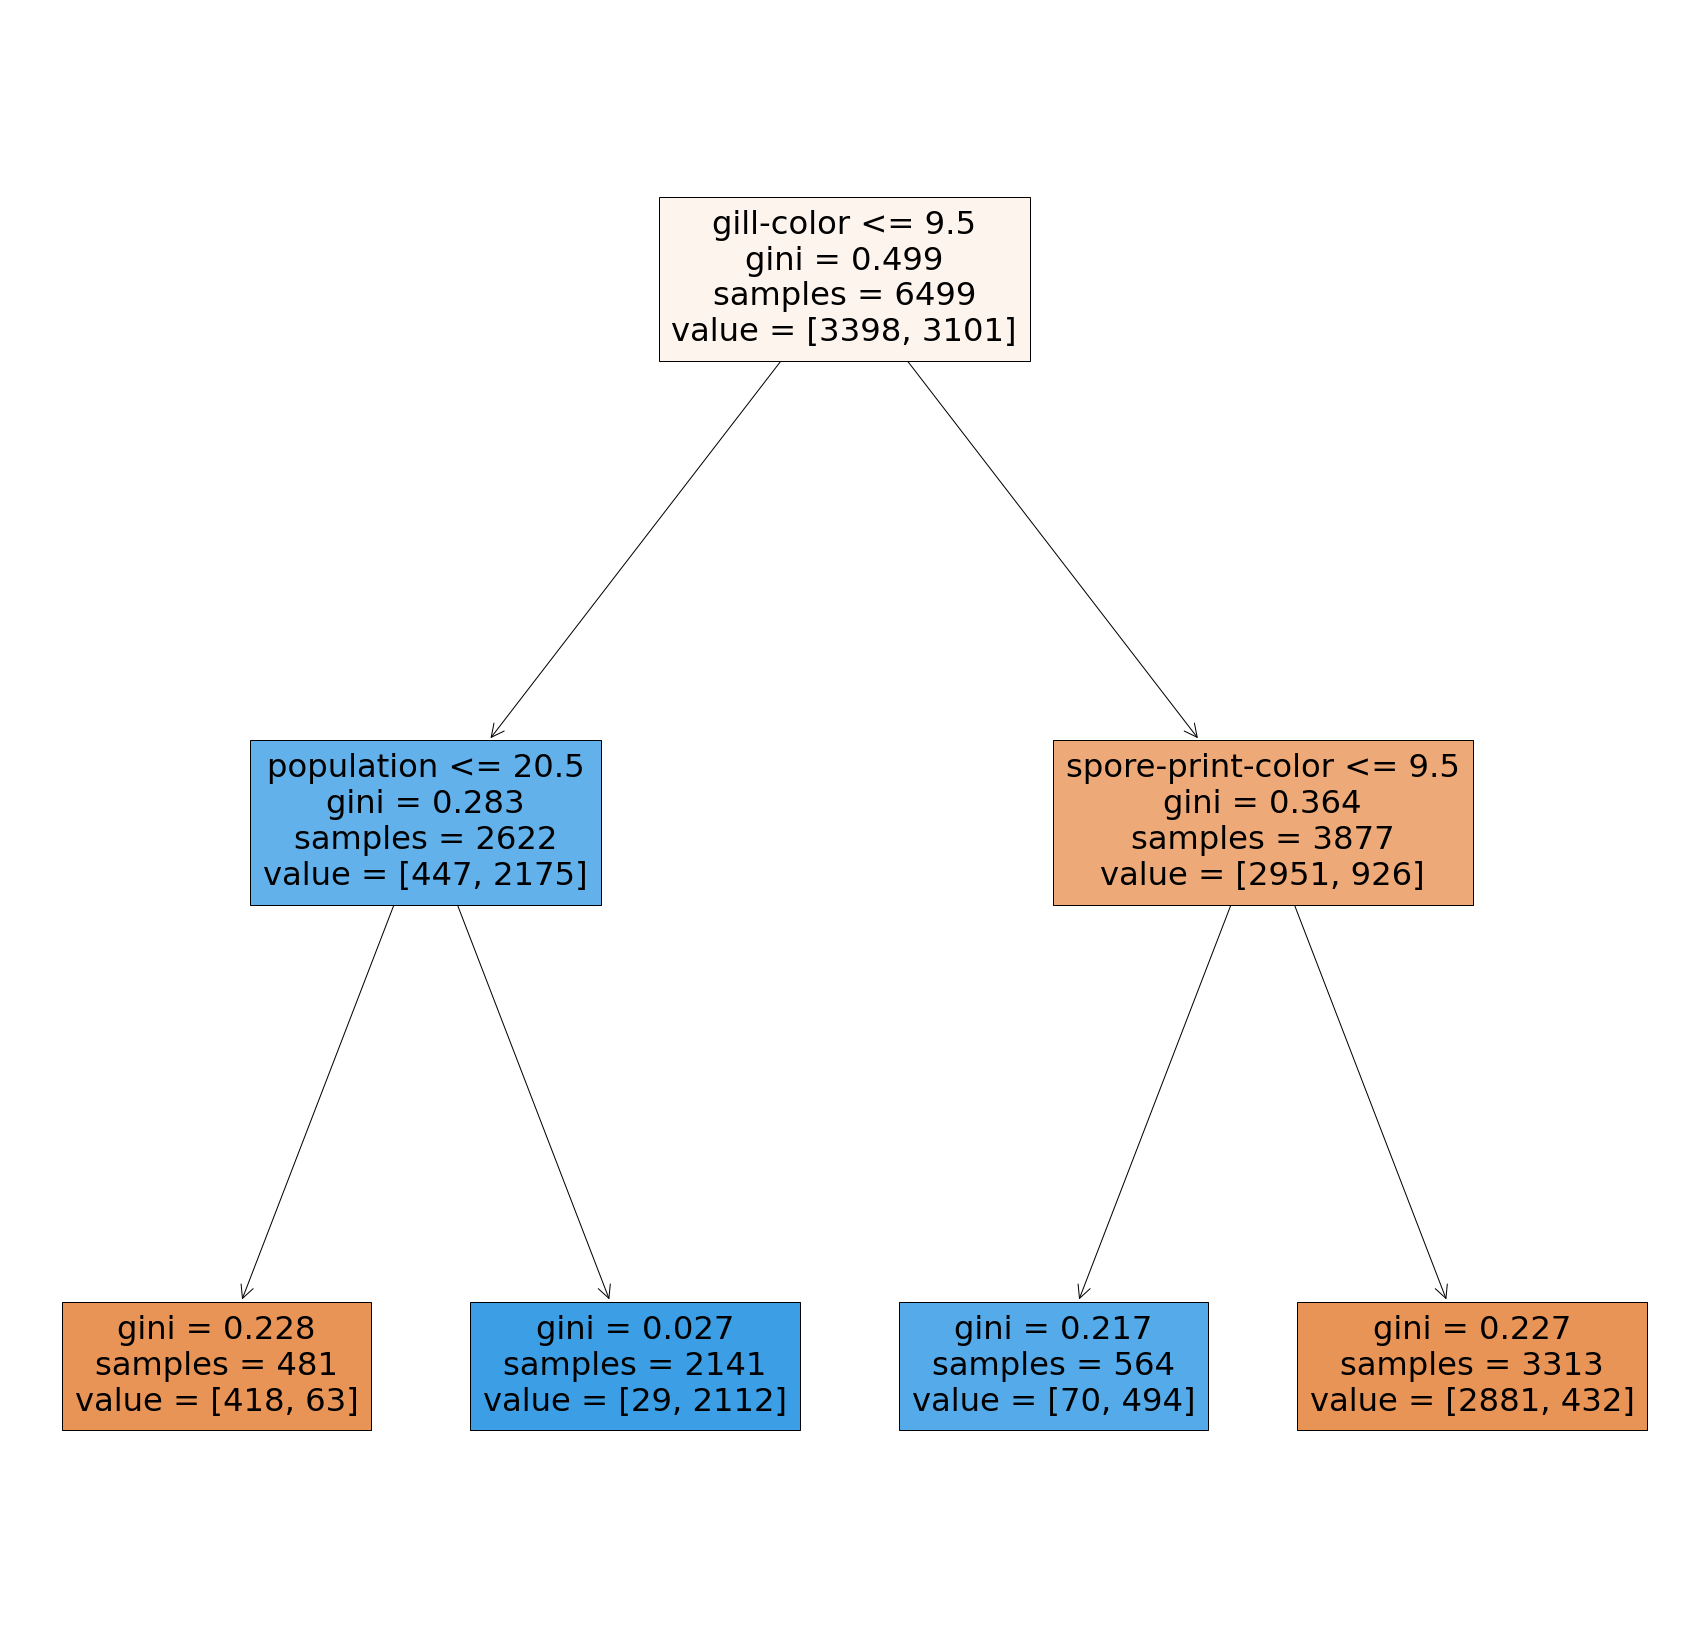

In [31]:
modifiedModel = tree.DecisionTreeClassifier(max_depth=2)
timeStart = time.time()
modifiedModel.fit(X_train,y_train)
timeEnd = time.time()

prediction = modifiedModel.predict(X_test)
accuracy = metrics.accuracy_score(prediction,y_test) #mean accuracy on the predictions of X_test with respect to y_test
precision = metrics.precision_score(prediction,y_test, average='micro') #mean precision on the predictions of X_test with respect to y_test
#while this is a binary classification (a mushroom is either 'e' or 'p'), sklearn would not allow a 'binary' average when scoring precision


print('The accuracy of the 2-depth tree is %0.2f%%, with a precision of %0.2f%%, taking %0.4f seconds to train.' % (accuracy*100, precision*100, timeEnd-timeStart))

fig = plt.figure(figsize=(30,30))
tree.plot_tree(modifiedModel, filled=True, feature_names=colNames[1:])
fig.savefig("shallow_depth_tree.png")

This two-level shallow tree retains ~92% accuracy on the dataset, and trains in even less time. This accuracy is low enough and the tree simple enough that the model is unlikely to be overfitting the data.

---

Next, we'll implement a bagging method on this data set, via the random forest algorithm. This will use the RandomForestClassifier from scikit-learn, whose accuracy will be analyzed with a repeated stratified k-fold from the same library.

K-Fold cross validation works by sectioning the data into k independent folds, where k is an integer. It then trains k-1 models, using one fold to train each, and uses the remaining fold to test the trained model. Every model will use a different fold for testing. 

Each model will have its own performance estimate. We report the mean of these estimates as the score of the overall performance estimate.

In [32]:
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

randomForestModel = RandomForestClassifier(n_estimators=50) #increasing n_estimators past 1 doesn't seem to have an affect on accuracy, but it does increase training time drastically
shuffle(X, y, random_state=42)

# to evaluate precision here, labels must be binarized
# I'm not sure of the exact reasoning and process behind what label binarization does, but this thread had a useful example: https://stackoverflow.com/questions/27357121/scikit-calculate-precision-and-recall-using-cross-val-score-function
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
yBinarized = np.array([num[0] for num in lb.fit_transform(y)])

# evaluate the model
timeStart = time.time()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
accuracyScores = cross_val_score(randomForestModel, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
precisionScores = cross_val_score(randomForestModel, X, yBinarized, scoring='precision', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
timeEnd = time.time()

# report performance
print('The accuracy of the random forest has mean %.2f (stddev %.2f%%).' % (np.mean(accuracyScores)*100, np.std(accuracyScores)))
print('The precision of the random forest has mean %.2f (stddev %.2f%%).' % (np.mean(precisionScores)*100, np.std(precisionScores)))
print('The model took %.4f seconds to train.' % (timeEnd-timeStart))

The accuracy of the random forest has mean 100.00 (stddev 0.00%).
The precision of the random forest has mean 100.00 (stddev 0.00%).
The model took 9.4971 seconds to train.


The random forest algorithm works by building a 'forest' of trees, each one with different structures, whose predictions then get averaged for the final output. The idea is that a large, diverse group of weak learners is overall stronger than a strong learner on its own.

This works well if an individual tree would have a high error rate, but doesn't have much effect if the forest is homogenous and trees stand well on their own.

This forest, with a population of 50, is overfitting, with a mean accuracy of 100%. 

Let's see how having a forest of trees compares to a single tree:

In [33]:
randomForestModel = RandomForestClassifier(n_estimators=1)
shuffle(X, y, random_state=42)

# evaluate the model
timeStart = time.time()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
accuracyScores = cross_val_score(randomForestModel, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
precisionScores = cross_val_score(randomForestModel, X, yBinarized, scoring='precision', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
timeEnd = time.time()

# report performance
print('The accuracy of the lone tree has mean %.2f (stddev %.2f%%)' % (np.mean(accuracyScores)*100, np.std(accuracyScores)))
print('The precision of the lone tree has mean %.2f (stddev %.2f%%)' % (np.mean(precisionScores)*100, np.std(precisionScores)))
print('The model took %.4f seconds to train.' % (timeEnd-timeStart))

The accuracy of the lone tree has mean 99.97 (stddev 0.00%)
The precision of the tree has mean 99.99 (stddev 0.00%)
The model took 0.6551 seconds to train.


The single tree has a slightly lower accuracy, but at 99.97% it's also overfitting. If an individual tree were underfitting, a forest would be able to counteract that bias. Each tree would pick up on different patterns present in the data, and combine their predictions for a more accurate average prediction. Here, random forest is not an appropriate model, it's too prone to overfitting the data.

Each tree has to be trained individually, so as the population of trees increases, so does the overall training time. Here, the training times are low enough that it doesn't matter, but in larger datasets it can be an important consideration.

---

For the boosting method, we'll implement an ADA boost classifier. This algorithm works by sequentially training models. As a model is trained, its errors are identified and assigned a higher 'weight' for the next model to train with. This allows for future models to rectify errors identified in previous models, and quickly if the learning rate is set appropriately.

We'll use the ADABoostClassifier from scikit-learn, with default parameters:

In [40]:
from sklearn.ensemble import AdaBoostClassifier

adaBoostModel = AdaBoostClassifier(n_estimators=50)

timeStart = time.time()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
accuracyScores = cross_val_score(adaBoostModel, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
precisionScores = cross_val_score(adaBoostModel, X, yBinarized, scoring='precision', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
#while this is a binary classification (a mushroom is either 'e' or 'p'), sklearn would not allow a 'binary' average when scoring precision
timeEnd = time.time()

print('The accuracy of the 50 ADA boost classifier has mean %.2f (stddev %.2f%%)' % (np.mean(accuracyScores)*100, np.std(accuracyScores)))
print('The precision of the 50 ADA boost classifier has mean %.2f (stddev %.2f%%)' % (np.mean(precisionScores)*100, np.std(precisionScores)))
print('The model took %.4f seconds to train.' % (timeEnd-timeStart))

The accuracy of the 50 ADA boost classifier has mean 100.00 (stddev 0.00%)
The precision of the 50 ADA boost classifier has mean 100.00 (stddev 0.00%)
The model took 15.0305 seconds to train.


This model is clearly overfitting. Let's examine the first classifier to see if the problem can be rectified with a lower classifier count:



In [41]:
adaBoostModel = AdaBoostClassifier(n_estimators=1)

timeStart = time.time()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
accuracyScores = cross_val_score(adaBoostModel, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
precisionScores = cross_val_score(adaBoostModel, X, yBinarized, scoring='precision', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
#while this is a binary classification (a mushroom is either 'e' or 'p'), sklearn would not allow a 'binary' average when scoring precision
timeEnd = time.time()

print('The accuracy of the lone ADA boost classifier has mean %.2f (stddev %.2f%%)' % (np.mean(accuracyScores)*100, np.std(accuracyScores)))
print('The precision of the lone ADA boost classifier has mean %.2f (stddev %.2f%%)' % (np.mean(precisionScores)*100, np.std(precisionScores)))
print('The model took %.4f seconds to train.' % (timeEnd-timeStart))

The accuracy of the lone ADA boost classifier has mean 79.02 (stddev 0.01%)
The precision of the lone ADA boost classifier has mean 83.44 (stddev 0.01%)
The model took 0.6175 seconds to train.


A single classifier trained under ADA boost here shows ~79% accuracy, a relatively poor result. It's likely underfitting. Through testing, it appears that somewhere between five (acc. ~93%) and seven (acc. ~95%) classifiers provides a good balance between bias and variance. 

Let's split the difference and look at the results for six estimators:

In [45]:
adaBoostModel = AdaBoostClassifier(n_estimators=6)

timeStart = time.time()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
accuracyScores = cross_val_score(adaBoostModel, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
precisionScores = cross_val_score(adaBoostModel, X, yBinarized, scoring='precision', cv=cv, n_jobs=-1, error_score='raise') #k-fold cross validation splits the data for us, so we can use the whole X and y
#while this is a binary classification (a mushroom is either 'e' or 'p'), sklearn would not allow a 'binary' average when scoring precision
timeEnd = time.time()

print('The accuracy of the 6 ADA boost classifier has mean %.2f (stddev %.2f%%)' % (np.mean(accuracyScores)*100, np.std(accuracyScores)))
print('The precision of the 6 ADA boost classifier has mean %.2f (stddev %.2f%%)' % (np.mean(precisionScores)*100, np.std(precisionScores)))
print('The model took %.4f seconds to train.' % (timeEnd-timeStart))

The accuracy of the 6 ADA boost classifier has mean 94.75 (stddev 0.01%)
The precision of the 6 ADA boost classifier has mean 96.16 (stddev 0.01%)
The model took 2.1663 seconds to train.


This is a good result. ADA boost is a better-suited model for this problem and dataset, random forest overfits too easily.

---


Accuracy has been the primary metric used for comparison throughout this notebook. 

This is a classification problem. Accuracy measures the ratio of correct guesses to all guesses. When looking to see how many predictions are correct in a series of guesses, accuracy is a good metric to use, which is why it has been the primary metric for comparison here. For example, in the above ADA boost classifier with 6 estimators, the accuracy was ~95%. This means that for every hundred mushrooms the classifier tries to identify, it will correctly identify about 95 of them. Accuracy also tends to work well when there's a roughly even split of target classes, which is true here (it's a 3399-3100 split, which can be seen in the upper node of all tree visualizations.

Throughout the notebook, the precision of each model has also been measured. Precision measures how likely an outcome is to truly be that outcome. If applying these models in the real world to know if a mushroom is edible or not, precision would be crucial. The developer should be confident that the models' prediction is as precise as possible, or they risk making their users sick. This model is not being relied upon for that purpose, but it could be a consideration in others.

For each model, the precision has been equal to or just slightly higher than accuracy. It would not significantly change the results.